# CESM2 Large Ensemble 2 Investiagtion

Daily files are located under `/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/WSPDSRFAV/*` on the NCAR server.

__Variables analyzed__
- `WSPDSRFAV`: Horizontal total wind speed average at the surface [$m \ s^{-1}$]
- _WSPDSRFAV anomaly_: artificially constructed according to $x_i-\bar{x}_{\text{time}}$

For this study, anomalies are calculated relative to the historical reference period, 1978-2014. Thus $\bar{x}_{\text{time}} = \bar{x}_{1978-2014}$

In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import nc_time_axis
import numpy as np
import pandas as pd
import pwlf
import xarray as xr
import cf_xarray as cfxr   # to use cf_xarray attributes
import regionmask
from glob import glob
import scienceplots
import string
import scipy
%matplotlib inline
plt.style.use(["nature", "notebook"])

xr.set_options(keep_attrs=True)
%load_ext rich
from rich import print  # pretty printing
from tqdm import tqdm  # progress bar
import warnings  # deal with warnings

# To access collection
import dask
import intake
from dask_jobqueue import PBSCluster
from dask.distributed import Client

# Play nice with CMIP6 data
import xclim.ensembles as ensembles

## Helper functions

Issue: this is very slow for some reason

In [2]:
def mask_data(data, map, regions: None, drop=False, reverse=False):
    """Mask xarray data based on region names

    Args:
        data (xarray dataset): xarray dataset to mask
        map (regionmask): regionmask object
        regions (list or None): list of region names to mask. if None, all regions are taken. Defaults to None.
        drop (bool, optional): Whether to drop when masking. Defaults to False.
        reverse (bool, optional): Whether to mask the inverse of the regions. Defaults to False.

    Returns:
        xarray dataset: masked dataset
    """
    # Load the region mask
    mask = map.mask(data)
    # Extract keys for the region
    id_dict = map.region_ids
    # Get region names
    if regions is None:
        names = id_dict.keys()
    else:
        # Coerce region names to uppercase
        regions_upper = [region.upper() for region in regions]
        names = [name for name in id_dict.keys() if str(name).upper() in regions_upper]
        assert len(names) == len(regions), 'Not enough regions found'
    # Get the key for the regions
    keys = [id_dict[name] for name in names]
    # Apply the mask to the data
    if reverse:
        masked_data = data.where(~mask.isin(keys), drop=drop)
    else:
        masked_data = data.where(mask.isin(keys), drop=drop)
    return masked_data

def p_val(r, n,  lat, lon):
    var = np.diag(r.polyfit_covariance.sel(lat=lat, lon=lon))
    #The standard error of the parameter estimates from the variance-covariance matrix is the square root of the diagonal values
    std_err = np.sqrt(var)
    # std_err = std/np.sqrt(n)
    t = r.sel(lat=lat, lon=lon).polyfit_coefficients.values/std_err
    # Degrees of freedom = n-2 (fit two parameters)
    df = n-2
    # Only need to test for slop (degree=1)
    t = t[1]
    return scipy.stats.t.sf(abs(t), df=df)

## Spin up Dask cluster

In [3]:
# Create our NCAR Cluster - which uses PBSCluster under the hood
num_jobs = 10
cluster = PBSCluster(
    job_name = 'valencig-dask-hpc',
    cores = 1,
    memory = '10GiB',
    local_directory = '/glade/u/home/valencig/spilled/',
    log_directory = '/glade/u/home/valencig/worker-logs/',
    queue = 'casper',
    walltime = '02:00:00', # Change wall time if needed
    interface = 'ext'
)


# Spin up workers
cluster.scale(jobs=num_jobs)

# Assign the cluster to our Client
client = Client(cluster)

# Block progress until workers have spawned
client.wait_for_workers(num_jobs)
client

/glade/u/home/valencig/.conda/envs/wind/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34441 instead
  warnings.warn(


<Client: 'tcp://128.117.208.103:41993' processes=9 threads=9, memory=90.00 GiB>

## Create ensemble

### Get simulation names

- `smbb`: smoothed biomass burning (more info [here](https://www.cesm.ucar.edu/community-projects/lens2))
- `cmip6`: classic CMIP6 forcings

In [4]:
# Get list of all files
all_files = glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/WSPDSRFAV/*')
# Simulation runs
simulation_names = set([f.split('.')[2] for f in all_files])
simulation_names

{'BHISTsmbb', 'BHISTcmip6', 'BSSP370cmip6', 'BSSP370smbb'}

### Load simulations

In [5]:
# Create dict to store all variants
simulations = dict()

for sim in simulation_names:
    # Extract all member numbers
    sim_files = [f for f in all_files if f.split('.')[2] == sim]
    members = list(set([f.split('.')[4] for f in sim_files]))
    # Create list to store datasets for each member
    sim_list = []
    for member in tqdm(members, desc=f"{sim} - Loading members..."):
        # Get files for this member
        m_files = [f for f in sim_files if f.split('.')[4] == member]
        # Load dataset
        ds = xr.open_mfdataset(m_files, parallel=True)
        # Remove 2100 or 2015 for historical data (data extends to 2099)
        if 'HIST' in sim:
            sliced = ds.sel(time=slice('1978', '2014'))
        elif 'SSP370' in sim:
            sliced = ds.sel(time=slice(None, '2099'))
        # Expand dimension name
        sim_list.append(sliced.WSPDSRFAV)
    simulation = ensembles.create_ensemble(sim_list, realizations=members)
    yearly = simulation.groupby('time.year').mean()  # No need to store daily data
    # Add to dict
    simulations[sim] = yearly.persist().compute()  # This step is slow but speeds up later computation

BSSP370smbb - Loading members...: 100%|██████████| 14/14 [00:30<00:00,  2.21s/it]


## Combine simulations by forcing variant

Determine anomaly relative to 1978-2014 mean windspeeds

In [6]:
cmip6_raw = xr.combine_by_coords([
    simulations['BHISTcmip6'].sortby('realization'),
    simulations['BSSP370cmip6'].sortby('realization')
])
smbb_raw = xr.combine_by_coords([
    simulations['BHISTsmbb'].sortby('realization'),
    simulations['BSSP370smbb'].sortby('realization')
])
forcings = dict(
    cmip6=cmip6_raw - cmip6_raw.sel(year=slice(1978, 2014)).mean('year'),
    smbb=smbb_raw - smbb_raw.sel(year=slice(1978, 2014)).mean('year'),
)

## Global

### Time series

Anomalies relative to 1978-2014 mean.

Error bars represent 25th and 75th quantiles.

Vertical line respresents GSOD derived reversal in stilling.

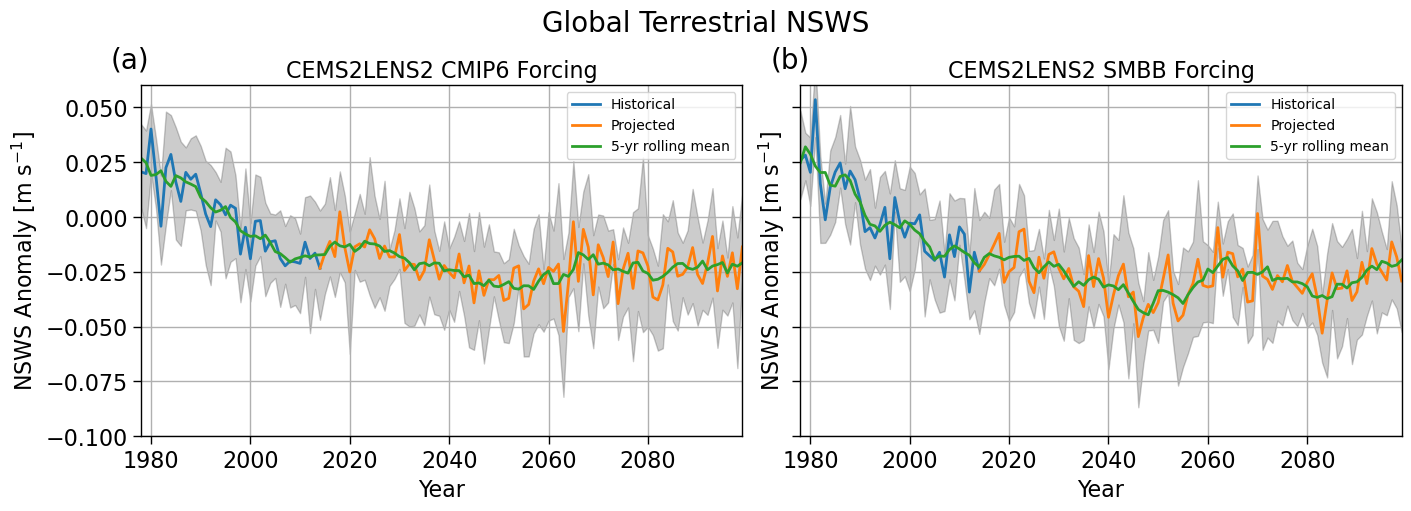

In [20]:
years = np.arange(1978, 2100)  # 1978-2099
# Masking regions
land_region = regionmask.defined_regions.natural_earth_v5_0_0.land_110  # Land has value 0
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

# Dict to store timeseries values
forcing_ts = dict()

# Make plot
fig, axes = plt.subplots(figsize=(14, 5), nrows=1, ncols=2, sharey=True, sharex=True, layout="constrained")

for i, force in enumerate(forcings.keys()):
    ax = axes[i]
    # mask to land
    land = mask_data(forcings[force], land_region, ['land'], drop=True)
    # Eliminate the planet of Hoth
    land = mask_data(land, countries, ['greenland'], reverse=True, drop=True)
    land = land.where((land['lat']>-59).compute(), drop=True)  # antarctica
    land = land.where((land['lat']<70).compute(), drop=True)  # Northern canada
    # Get timeseries
    land_ts = land.mean(['lat', 'lon'])
    # Reduce the simulation
    en_stats = ensembles.ensemble_mean_std_max_min(land_ts)['WSPDSRFAV_mean']
    rolled = en_stats.rolling(year=5, min_periods=1, center=True).mean()
    # Percentiles
    per = ensembles.ensemble_percentiles(land_ts, values=[25, 75], split=True)
    # errs = np.array([per['WSPDSRFAV_p25'], per['WSPDSRFAV_p75']])
    # Plot past
    ax.plot(years[years <= 2014], en_stats[years <= 2014], label='Historical')
    # Plot future (include 2014 so plot connects)
    ax.plot(years[years >= 2014], en_stats[years >= 2014], linewidth=2, label='Projected')
    # Other stats
    ax.plot(years, rolled, label='5-yr rolling mean')
    ax.fill_between(years, per['WSPDSRFAV_p25'], per['WSPDSRFAV_p75'], color='k', alpha=0.2)
    # Plot 1 - Options
    ax.set_title(f'CESM2LENS2 {force.upper()} Forcing')
    
# Options for both plots
for n, ax in enumerate(axes):
    ax.legend(fontsize=10)
    ax.grid(True)
    ax.set_xlabel('Year')
    ax.set_ylabel('NSWS Anomaly [m s$^{-1}$]')
    # ax.vlines(2010, -0.1, 0.1, color='k', linestyle='--')
    ax.set_xlim(years[0], years[-1])
    ax.set_ylim(-0.1, 0.06)
    # Add subplot label
    ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=20)
fig.suptitle('Global Terrestrial NSWS', fontsize=20)

# Caption
print('Anomalies relative to 1978-2014 mean.')
print('Error bars represent 25th and 75th quantiles.')
print('Vertical line respresents GSOD derived reversal in stilling.')

# Save figure
plt.savefig('figures/cesm2lens2_time_series_global.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### Spatial plot

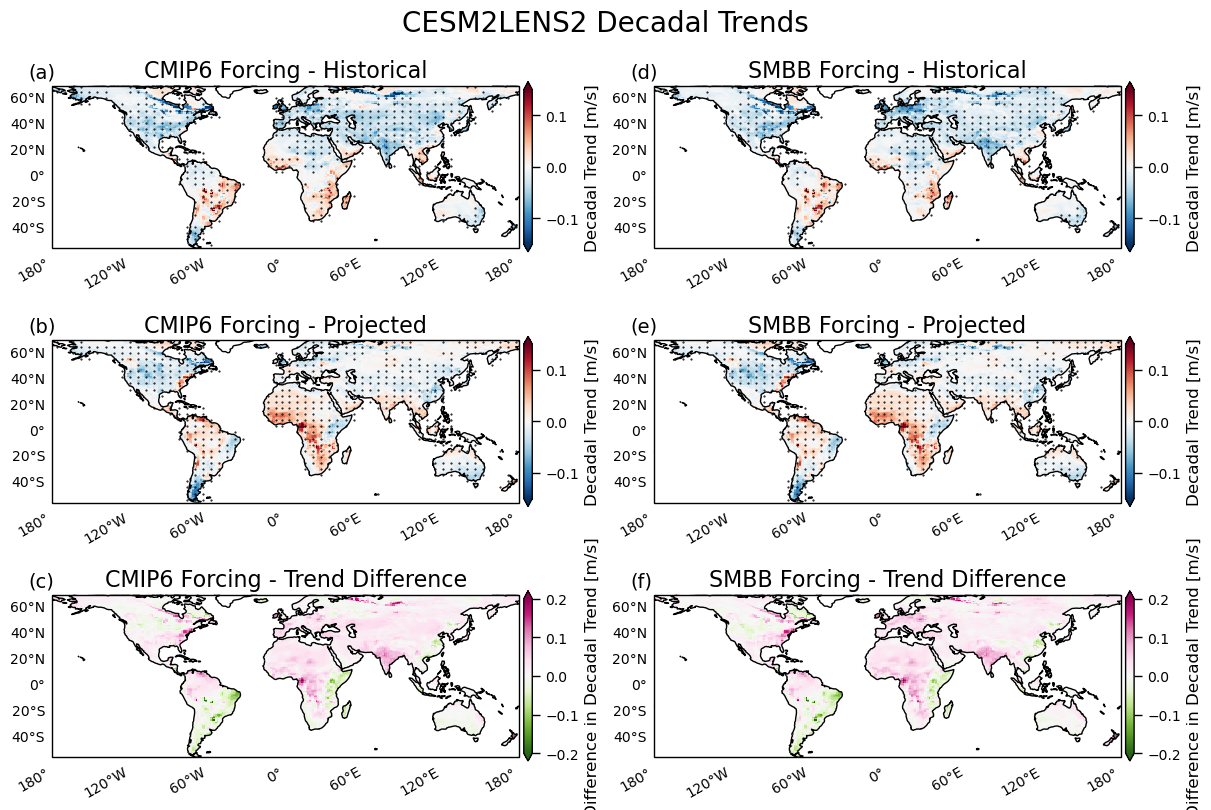

In [11]:
fig = plt.figure(figsize=(12, 8), constrained_layout=True)
gs = fig.add_gridspec(3, 2, width_ratios=[1, 1])  # left plot spatial, right plot signifigance
n = 0  # for subplot labels
for i, force in enumerate(forcings.keys()):
    # mask to land
    land = mask_data(forcings[force], land_region, ['land'], drop=True)
    # Eliminate the planet of Hoth
    land = mask_data(land, countries, ['greenland'], reverse=True, drop=True)
    land = land.where((land['lat']>-59).compute(), drop=True)  # antarctica
    land = land.where((land['lat']<70).compute(), drop=True)  # Northern canada
    # Create axes for plotting
    h = fig.add_subplot(gs[0, i], projection=ccrs.PlateCarree())
    f = fig.add_subplot(gs[1, i], projection=ccrs.PlateCarree())
    d = fig.add_subplot(gs[2, i], projection=ccrs.PlateCarree())
    # Reduce the simulation
    en_stats = ensembles.ensemble_mean_std_max_min(land)['WSPDSRFAV_mean']
    # Get trends 
    hist_trend = (
        en_stats.sel(year=slice(None, 2014))
        .polyfit('year', deg=1, skipna=True, cov=True)
    )
    future_trend = (
        en_stats.sel(year=slice(2015, None))
        .polyfit('year', deg=1, skipna=True, cov=True)
    )
    hist_coef = hist_trend.polyfit_coefficients.sel(degree=1)*10  # decadal
    future_coef = future_trend.polyfit_coefficients.sel(degree=1)*10  # decadal
    # Plot 1 - historical plot
    im = hist_coef.plot(ax=h, vmin=-0.15, vmax=0.15, cmap='RdBu_r', transform=ccrs.PlateCarree(), add_colorbar=False)
    cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=0.7)
    cb.ax.tick_params(labelsize=10)
    cb.set_label(label='Decadal Trend [m/s]', fontsize=12)
    h.set_title(f'{force.upper()} Forcing - Historical')
    hist_trend = hist_trend.coarsen(lon=5, lat=5, boundary='pad').mean()
    for lat in hist_trend.lat:
        for lon in hist_trend.lon:
            if p_val(hist_trend, 37, lat, lon) < 0.05:  # 37 years 1978-2014
                h.plot(lon, lat, 'ko', transform=ccrs.PlateCarree(), markersize=0.5)
    # Plot 2 - future plot
    im = future_coef.plot(ax=f, vmin=-0.15, vmax=0.15, cmap='RdBu_r', transform=ccrs.PlateCarree(), add_colorbar=False)
    cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=0.7)
    cb.ax.tick_params(labelsize=10)
    cb.set_label(label='Decadal Trend [m/s]', fontsize=12)
    f.set_title(f'{force.upper()} Forcing - Projected')
    future_trend = future_trend.coarsen(lon=5, lat=5, boundary='pad').mean()
    for lat in future_trend.lat:
        for lon in future_trend.lon:
            if p_val(future_trend, 37, lat, lon) < 0.05:  # 37 years 1978-2014
                f.plot(lon, lat, 'ko', transform=ccrs.PlateCarree(), markersize=0.5)
    # Plot 3 - Difference
    im = (future_coef-hist_coef).plot(ax=d, cmap='PiYG_r', vmin=-0.2, vmax=0.2, transform=ccrs.PlateCarree(), add_colorbar=False)
    cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=0.7)
    cb.ax.tick_params(labelsize=10)
    cb.set_label(label='Difference in Decadal Trend [m/s]', fontsize=12)
    d.set_title(f'{force.upper()} Forcing - Trend Difference')
    # Need to deal with covariance matrix of combined variables



    for ax in [h, f, d]:
        # Add label
        ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=14)
        n += 1
        # Map options
        ax.add_feature(cfeature.COASTLINE)
        gl = ax.gridlines(
            crs=ccrs.PlateCarree(), draw_labels=True, which='both',
            linewidth=1, color='k', alpha=1, linestyle='--'
        )
        gl.right_labels = None
        gl.top_labels = None
        gl.xlines = None
        gl.ylines = None
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        # Increase the ticksize
        gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':30, 'ha':'right'}
        gl.ylabel_style = {'size': 10, 'color': 'k', 'weight': 'normal'}
fig.suptitle('CESM2LENS2 Decadal Trends', fontsize=20)

plt.savefig('figures/cesm2lens2_global_trend.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## CONUS

### Time series

Anomalies relative to 1978-2014 mean.

Error bars represent 25th and 75th quantiles.

Vertical line respresents GSOD derived reversal in stilling.

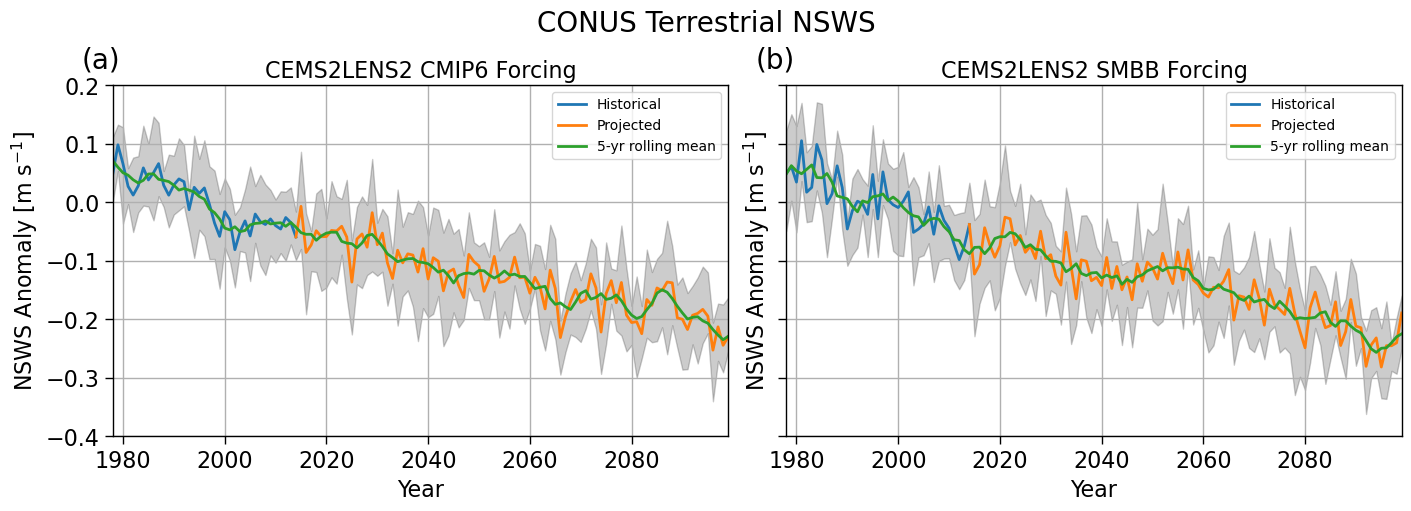

In [21]:
us_states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50
years = np.arange(1978, 2100)  # 1978-2099
# Masking regions
land_region = regionmask.defined_regions.natural_earth_v5_0_0.land_110  # Land has value 0
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

# Make plot
fig, axes = plt.subplots(figsize=(14, 5), nrows=1, ncols=2, sharey=True, sharex=True, layout="constrained")

for i, force in enumerate(forcings.keys()):
    ax = axes[i]
    us = mask_data(forcings[force], us_states, regions=None, drop=True)
    conus = mask_data(us, us_states, ['alaska', 'hawaii'], reverse=True, drop=True)
    conus = conus.where(conus.notnull(), drop=True)
    # Get timeseries
    conus_ts = conus.mean(['lat', 'lon'])
    # Reduce the simulation
    en_stats = ensembles.ensemble_mean_std_max_min(conus_ts)['WSPDSRFAV_mean']
    rolled = en_stats.rolling(year=5, min_periods=1, center=True).mean()
    # Percentiles
    per = ensembles.ensemble_percentiles(conus_ts, values=[25, 75], split=True)
    # errs = np.array([per['WSPDSRFAV_p25'], per['WSPDSRFAV_p75']])
    # Plot past
    ax.plot(years[years <= 2014], en_stats[years <= 2014], label='Historical')
    # Plot future (include 2014 so plot connects)
    ax.plot(years[years >= 2014], en_stats[years >= 2014], linewidth=2, label='Projected')
    # Other stats
    ax.plot(years, rolled, label='5-yr rolling mean')
    ax.fill_between(years, per['WSPDSRFAV_p25'], per['WSPDSRFAV_p75'], color='k', alpha=0.2)
    # Plot 1 - Options
    ax.set_title(f'cesm2LENS2 {force.upper()} Forcing')
    
# Options for both plots
for n, ax in enumerate(axes):
    ax.legend(fontsize=10)
    ax.grid(True)
    ax.set_xlabel('Year')
    ax.set_ylabel('NSWS Anomaly [m s$^{-1}$]')
    # ax.vlines(2010, -0.5, 0.5, color='k', linestyle='--')
    ax.set_xlim(years[0], years[-1])
    ax.set_ylim(-0.4, 0.2)
    # Add subplot label
    ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=20)
fig.suptitle('CONUS Terrestrial NSWS', fontsize=20)
    
# Caption
print('Anomalies relative to 1978-2014 mean.')
print('Error bars represent 25th and 75th quantiles.')
print('Vertical line respresents GSOD derived reversal in stilling.')

# Save figure
plt.savefig('figures/cesm2lens2_time_series_conus.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### Spatial plot

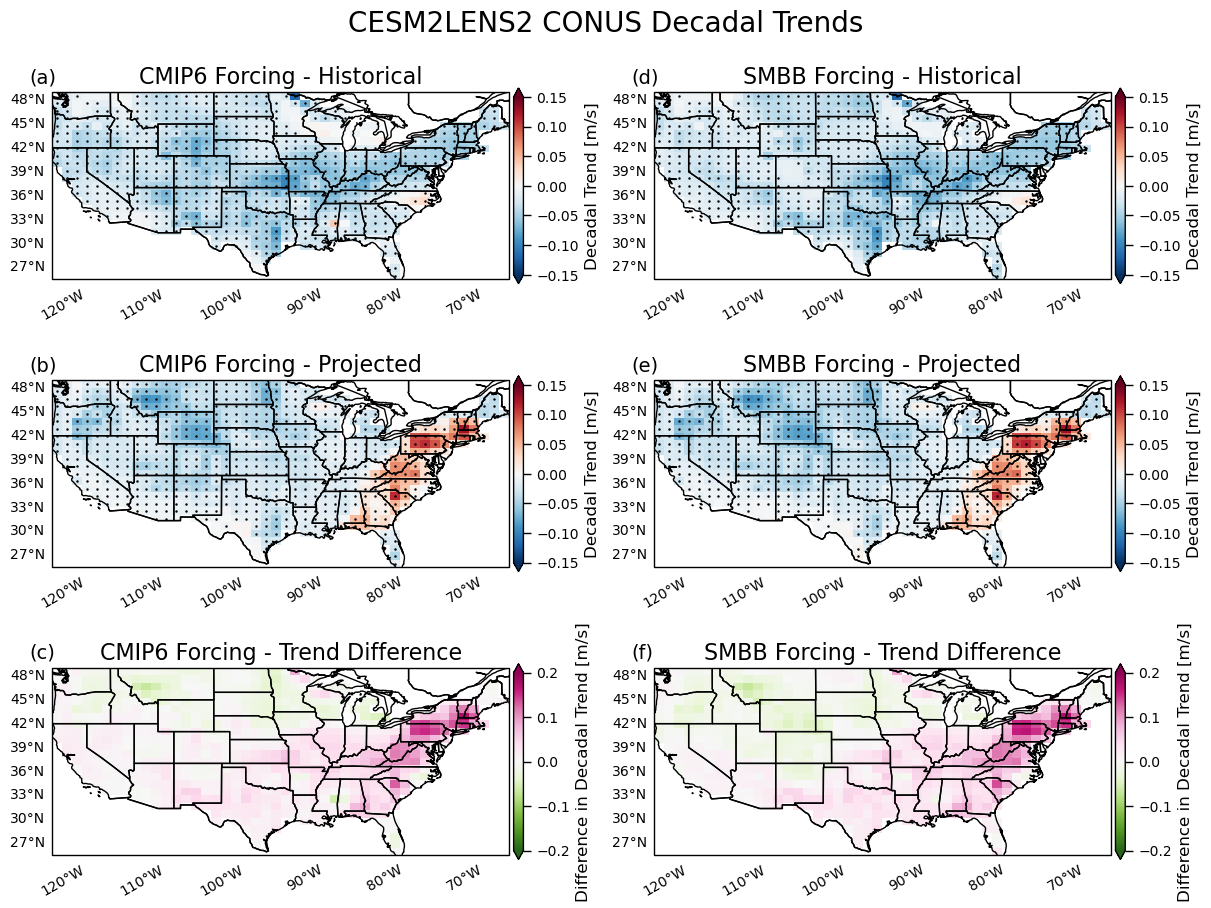

In [9]:
us_states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50

fig = plt.figure(figsize=(12, 9), constrained_layout=True)
gs = fig.add_gridspec(3, 2, width_ratios=[1, 1])  # left plot spatial, right plot signifigance
n = 0  # for subplot labels
for i, force in enumerate(forcings.keys()):
    # mask to land
    us = mask_data(forcings[force], us_states, regions=None, drop=True)
    conus = mask_data(us, us_states, ['alaska', 'hawaii'], reverse=True, drop=True)
    conus = conus.where(conus.notnull(), drop=True)
    # Create axes for plotting
    h = fig.add_subplot(gs[0, i], projection=ccrs.PlateCarree())
    f = fig.add_subplot(gs[1, i], projection=ccrs.PlateCarree())
    d = fig.add_subplot(gs[2, i], projection=ccrs.PlateCarree())
    # Reduce the simulation
    en_stats = ensembles.ensemble_mean_std_max_min(conus)['WSPDSRFAV_mean']
    # Get trends 
    hist_trend = (
        en_stats.sel(year=slice(None, 2014))
        .polyfit('year', deg=1, skipna=True, cov=True)
    )
    future_trend = (
        en_stats.sel(year=slice(2015, None))
        .polyfit('year', deg=1, skipna=True, cov=True)
    )
    hist_coef = hist_trend.polyfit_coefficients.sel(degree=1)*10  # decadal
    future_coef = future_trend.polyfit_coefficients.sel(degree=1)*10  # decadal
    # Plot 1 - historical plot
    im = hist_coef.plot(ax=h, vmin=-0.15, vmax=0.15, cmap='RdBu_r', transform=ccrs.PlateCarree(), add_colorbar=False)
    cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=0.7)
    cb.ax.tick_params(labelsize=10)
    cb.set_label(label='Decadal Trend [m/s]', fontsize=12)
    h.set_title(f'{force.upper()} Forcing - Historical')
    for lat in hist_trend.lat:
        for lon in hist_trend.lon:
            if p_val(hist_trend, 37, lat, lon) < 0.05:  # 37 years 1978-2014
                h.plot(lon, lat, 'ko', transform=ccrs.PlateCarree(), markersize=0.75)
    # Plot 2 - future plot
    im = future_coef.plot(ax=f, vmin=-0.15, vmax=0.15, cmap='RdBu_r', transform=ccrs.PlateCarree(), add_colorbar=False)
    cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=0.7)
    cb.ax.tick_params(labelsize=10)
    cb.set_label(label='Decadal Trend [m/s]', fontsize=12)
    f.set_title(f'{force.upper()} Forcing - Projected')
    for lat in future_trend.lat:
        for lon in future_trend.lon:
            if p_val(future_trend, 37, lat, lon) < 0.05:  # 37 years 1978-2014
                f.plot(lon, lat, 'ko', transform=ccrs.PlateCarree(), markersize=0.75)
    # Plot 3 - Difference
    im = (future_coef-hist_coef).plot(ax=d, cmap='PiYG_r', vmin=-0.2, vmax=0.2, transform=ccrs.PlateCarree(), add_colorbar=False)
    cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=0.7)
    cb.ax.tick_params(labelsize=10)
    cb.set_label(label='Difference in Decadal Trend [m/s]', fontsize=12)
    d.set_title(f'{force.upper()} Forcing - Trend Difference')
    # Need to deal with covariance matrix of combined variables

    for ax in [h, f, d]:
        # Add label
        ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=14)
        n += 1
        # Map options
        ax.add_feature(cfeature.STATES)
        ax.add_feature(cfeature.BORDERS)
        gl = ax.gridlines(
            crs=ccrs.PlateCarree(), draw_labels=True, which='both',
            linewidth=1, color='k', alpha=1, linestyle='--'
        )
        gl.right_labels = None
        gl.top_labels = None
        gl.xlines = None
        gl.ylines = None
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        # Increase the ticksize
        gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':30, 'ha':'right'}
        gl.ylabel_style = {'size': 10, 'color': 'k', 'weight': 'normal'}
fig.suptitle('CESM2LENS2 CONUS Decadal Trends', fontsize=20)

plt.savefig('figures/cesm2lens2_conus_trend.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Monthly Investigation

### Load Data

In [6]:
# Create dict to store all variants
mon_simulations = dict()

for sim in simulation_names:
    # Extract all member numbers
    sim_files = [f for f in all_files if f.split('.')[2] == sim]
    members = list(set([f.split('.')[4] for f in sim_files]))
    # Create list to store datasets for each member
    sim_list = []
    for member in tqdm(members, desc=f"{sim} - Loading members..."):
        # Get files for this member
        m_files = [f for f in sim_files if f.split('.')[4] == member]
        # Load dataset
        ds = xr.open_mfdataset(m_files)
        # Remove 2100 or 2015 for historical data (data extends to 2099)
        if 'HIST' in sim:
            sliced = ds.sel(time=slice('1978', '2014'))
        elif 'SSP370' in sim:
            sliced = ds.sel(time=slice(None, '2099'))
        # Expand dimension name
        sim_list.append(sliced.WSPDSRFAV)
    simulation = ensembles.create_ensemble(sim_list, realizations=members)
    monthly = simulation.resample(time="M").mean()  # No need to store daily data
    # Add to dict
    mon_simulations[sim] = monthly.persist().compute()  # This step is slow but speeds up later computation

BSSP370smbb - Loading members...: 100%|██████████| 14/14 [01:24<00:00,  6.04s/it]


### Combine by Forcing Variant

In [15]:
cmip6_raw = xr.combine_by_coords([
    mon_simulations['BHISTcmip6'].sortby('realization'),
    mon_simulations['BSSP370cmip6'].sortby('realization')
])
smbb_raw = xr.combine_by_coords([
    mon_simulations['BHISTsmbb'].sortby('realization'),
    mon_simulations['BSSP370smbb'].sortby('realization')
])
mon_forcings = dict(
    cmip6=cmip6_raw - cmip6_raw.sel(time=slice('1978', '2014')).mean(),
    smbb=smbb_raw - smbb_raw.sel(time=slice('1978', '2014')).mean(),
)

### CONUS

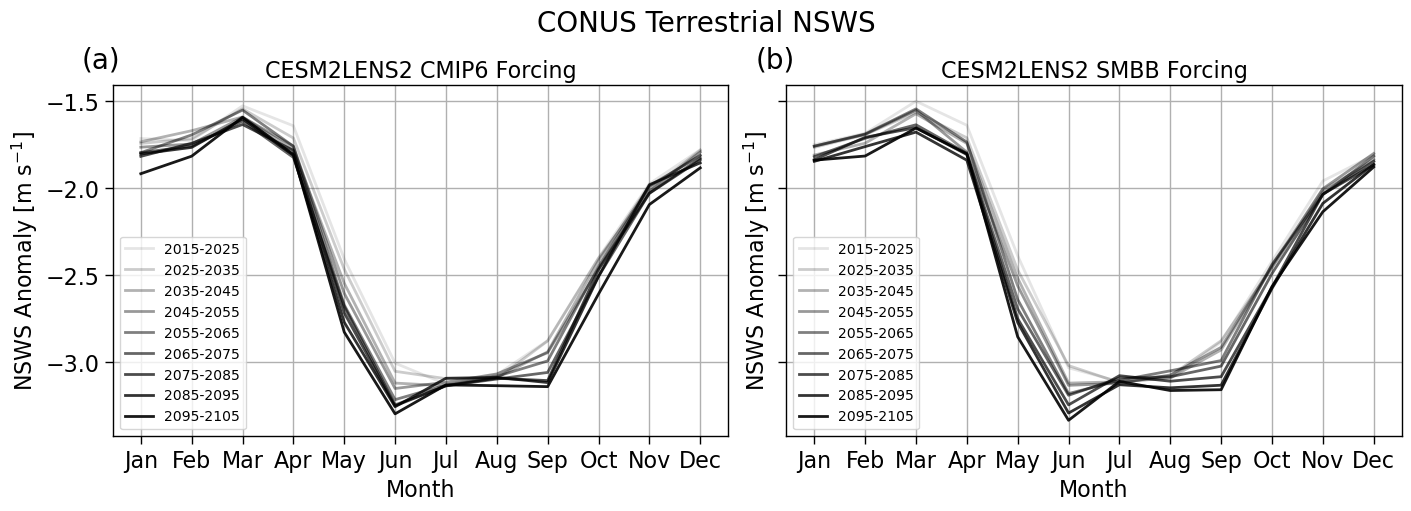

In [53]:
us_states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50
years = np.arange(1978, 2100)  # 1978-2099
# Masking regions
land_region = regionmask.defined_regions.natural_earth_v5_0_0.land_110  # Land has value 0
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

# Make plot
fig, axes = plt.subplots(figsize=(14, 5), nrows=1, ncols=2, sharey=True, sharex=True, layout="constrained")

for i, force in enumerate(mon_forcings.keys()):
    ax = axes[i]
    us = mask_data(mon_forcings[force], us_states, regions=None, drop=True)
    conus = mask_data(us, us_states, ['alaska', 'hawaii'], reverse=True, drop=True)
    conus = conus.where(conus.notnull(), drop=True)
    # Get time series
    conus_ts = conus.WSPDSRFAV.sel(time=slice('2015', '2100')).mean(['lat', 'lon', 'realization'])
    # Group by month
    for i, years in enumerate(np.arange(2015, 2100, 10)):
        start, stop = str(years), str(years+10)
        monthly = conus_ts.sel(time=slice(start, stop)).groupby('time.month').mean()
        monthly.plot(ax=ax, label=f'{start}-{stop}', color='k', alpha=0.1*(i+1))
    # Plot 1 - Options
    ax.set_title(f'CESM2LENS2 {force.upper()} Forcing')
    
# Options for both plots
for n, ax in enumerate(axes):
    ax.legend(fontsize=10)
    ax.grid(True)
    ax.set_xlabel('Month')
    ax.set_ylabel('NSWS Anomaly [m s$^{-1}$]')
    # ax.vlines(2010, -0.5, 0.5, color='k', linestyle='--')
    # ax.set_xlim(years[0], years[-1])
    # ax.set_ylim(-0.4, 0.2)
    ax.set_xticks(np.arange(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    # Add subplot label
    ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=20)

fig.suptitle('CONUS Terrestrial NSWS', fontsize=20)

# Save figure
plt.savefig('figures/cesm2lens2_monthly_evolution_conus.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Kill Dask Cluster

In [10]:
# client.shutdown()